# Projeto Final de Ciência de Dados

## Bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

## Introdução

Nome dos integrantes:

- **Nome**: Alan Teixeira da Costa, **Matrícula**: 2022100831, **E-mail**: alan.costa@edu.ufes.br
- **Nome**: Miguel Vieira Machado Pim, **Matrícula**: 2022100894, **E-mail**: miguel.pim@edu.ufes.br

O objetivo geral deste projeto final é praticar os conceitos estudados durante toda a disciplina de Introdução a Ciência de Dados, principalmente: web scraping e aprendizado supervisionado. Para isso iremos fazer scraping do site https://www.transfermarkt.com.br/ para poder prever resultados de partidas de futebol a partir de dados da premier league e do brasileirão.

## Descrição de Problema

Nosso problema consiste em construir um classificador capaz de prever resultados de partidas de futebol. Este classificador deverá classificar uma partida entre três possíveis resultados: vitória do time da casa, derrota do time da casa ou empate.

## Descrição do Conjunto de Dados

Para este projeto utilizaremos um conjunto de dados de partidas de futebol. Os dados foram obtidos utilizando web scraping para buscar partidas de ligas. O código do scraping pode ser visto no repositório https://github.com/Alan-TC/Scraper-T2-CienciaDeDados. Vale ressaltar que utilizamos apenas os dados de partidas de ligas desse repositório. No [script_concatenação](./pre_processer.ipynb) foi feito a transformação de todos os dataframes em apenas um.

Os dados estão organizados em um arquivo (```partidas.csv```) com as seguintes colunas:  

Colunas com informações sobre a partida, indepedente do time:  
- **capacidade_estadio**: Capacidade do estádio do time da casa (```int```)
- **publico_estadio**: Público total que compareceu ao jogo (```int```)
- **ano**: Ano em que o jogo aconteceu (```int```)
- **fase**: Rodada da liga em que o jogo aconteceu (```str```)  

Colunas com informações sobre os times. No arquivo, para cada coluna com "casa" no nome também existe uma coluna com "fora" no nome, que foram omitidas por terem características iguais:
- **time_casa**: Nome do time da casa (```str```)
- **gols_casa**: Quantidade de gols do time da casa (```int```)
- **posse_casa**: Quantidade de posse de bola do time da casa em porcentagem (```int```)
- **tentativas_casa**: Quantidade de chutes do time da casa (```int```)
- **chutes_fora_casa**: Quantidade de chutes pra fora do gol da casa (```int```)
- **defesa_casa**: Quantidade de defesas do goleiro do time da casa (```int```)
- **escanteios_casa**: Quantidade de escanteios do time da casa (```int```)
- **cobrancas_falta_casa**: Quantidade de cobranças de falta do time da casa (```int```)
- **faltas_cometidas_casa**: Quantidade de faltas cometidas pelo time da casa (```int```)
- **impedimentos_casa**: Quantidade de impedimentos do time da casa (```int```)

Portanto, no total temos 24 colunas do nosso dataframe.

In [2]:
partidas_df = pd.read_csv("partidas.csv")
partidas_df.head()

,capacidade_estadio,publico_estadio,time_casa,gols_casa,posse_casa,tentativas_casa,chutes_fora_casa,defesa_casa,escanteios_casa,cobrancas_falta_casa,...,posse_fora,tentativas_fora,chutes_fora_fora,defesa_fora,escanteios_fora,cobrancas_falta_fora,faltas_cometidas_fora,impedimentos_fora,ano,fase
0,26047,0,Crystal Palace FC,1,30,5,2,5,7,10,...,70,9,3,2,3,14,11,0,2021,1.Rodada
1,54074,0,FC Liverpool,4,49,22,3,0,9,5,...,51,6,1,3,0,9,6,5,2021,1.Rodada
2,60000,0,West Ham United,0,58,15,5,0,8,7,...,42,15,7,3,7,11,7,4,2021,1.Rodada
3,2685,0,West Bromwich Albion,0,37,7,3,4,2,9,...,63,13,3,1,5,11,9,3,2021,1.Rodada
4,62062,0,Tottenham Hotspur,0,51,9,1,3,5,6,...,49,15,7,5,3,14,7,1,2021,1.Rodada


## Metodologia

Para atingir o objetivo proposto utilizaremos os seguintes passos:  

- Pré-processamento dos dados (retirar colunas desnecessárias dos dados e adicionar a coluna com as labels).
- Aplicação de ao menos dois algoritmos de aprendizado supervisionado vistos em aula.
- Validação da metodologia utilizada.
- Interpretação dos resultados.

## Pré-processamento

### Adicionando coluna label

Os valores dos labels serão:  

- **Vitoria**: Vitória do time da casa
- **Empate**: Empate
- **Derrota**: Derrota do time da casa

In [3]:
def add_label_column(row):
    if (row["gols_casa"] > row["gols_fora"]):
        return 'Vitoria'
    elif (row["gols_casa"] < row["gols_fora"]):
        return 'Derrota'
    else:
        return 'Empate'

In [4]:
partidas_df["label"] = partidas_df.apply(add_label_column, axis=1)
partidas_df[["gols_casa", "gols_fora", "label"]].head()

,gols_casa,gols_fora,label
0,1,0,Vitoria
1,4,3,Vitoria
2,0,2,Derrota
3,0,3,Derrota
4,0,1,Derrota


### Transformando coluna da fase

In [5]:
partidas_df["fase"] = list(map(lambda x : int(x.split('.')[0]), partidas_df["fase"]))
partidas_df["fase"].head()

0    1
1    1
2    1
3    1
4    1
Name: fase, dtype: int64

### Retirando colunas desnecessárias

In [6]:
partidas_df.drop(columns=["time_casa", "time_fora", "gols_casa", "gols_fora"], inplace=True)
partidas_df.head()

,capacidade_estadio,publico_estadio,posse_casa,tentativas_casa,chutes_fora_casa,defesa_casa,escanteios_casa,cobrancas_falta_casa,faltas_cometidas_casa,impedimentos_casa,...,tentativas_fora,chutes_fora_fora,defesa_fora,escanteios_fora,cobrancas_falta_fora,faltas_cometidas_fora,impedimentos_fora,ano,fase,label
0,26047,0,30,5,2,5,7,10,14,4,...,9,3,2,3,14,11,0,2021,1,Vitoria
1,54074,0,49,22,3,0,9,5,9,2,...,6,1,3,0,9,6,5,2021,1,Vitoria
2,60000,0,58,15,5,0,8,7,13,2,...,15,7,3,7,11,7,4,2021,1,Derrota
3,2685,0,37,7,3,4,2,9,12,4,...,13,3,1,5,11,9,3,2021,1,Derrota
4,62062,0,51,9,1,3,5,6,15,0,...,15,7,5,3,14,7,1,2021,1,Derrota


### Verificando a proporção de vitória, derrota e empate para o time da casa

<Axes: xlabel='label', ylabel='Count'>

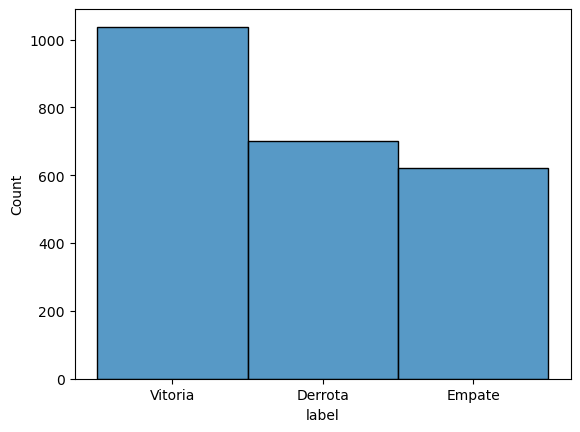

In [7]:
sns.histplot(partidas_df['label'])

## Aplicando algoritmos de classificação

Separando **partidas_df** em x e y

In [8]:
y = partidas_df["label"]
X = partidas_df.drop(columns=["label"])

Separando os dados em treino e teste

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

### KNN

#### Escolha do K

In [10]:
k_range = range(1, 50)
k_scores = []

for k in k_range:
    model = KNeighborsClassifier(n_neighbors = k)
    scaler = preprocessing.MinMaxScaler(feature_range = (0, 10))
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    scores = cross_val_score(model, X_train_scaled, y_train, cv = 5, scoring='accuracy')
    k_scores.append(scores.mean())

Text(0, 0.5, 'Acurácia do KNN')

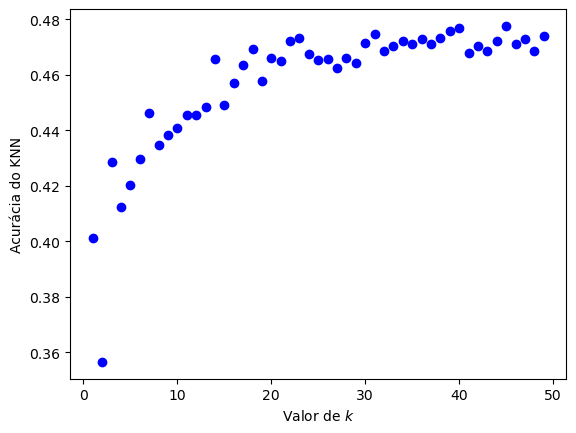

In [11]:
plt.scatter(k_range, k_scores, color = 'blue')
plt.xlabel(r'Valor de $k$')
plt.ylabel('Acurácia do KNN')

#### Normalizando - Definindo o scaler

In [12]:
scaler = preprocessing.MinMaxScaler(feature_range = (0, 10))
scaler.fit(X_train)

MinMaxScaler(feature_range=(0, 10))

#### Realizando o treinamento

In [13]:
k = 39
model = KNeighborsClassifier(n_neighbors = k)
X_train_scaled = scaler.transform(X_train)
model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=39)

#### Obtendo predição do conjunto de teste

In [14]:
X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)

#### Avaliando o classificador

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Derrota       0.36      0.35      0.36       199
      Empate       0.26      0.06      0.09       192
     Vitoria       0.50      0.74      0.60       317

    accuracy                           0.45       708
   macro avg       0.37      0.38      0.35       708
weighted avg       0.40      0.45      0.39       708



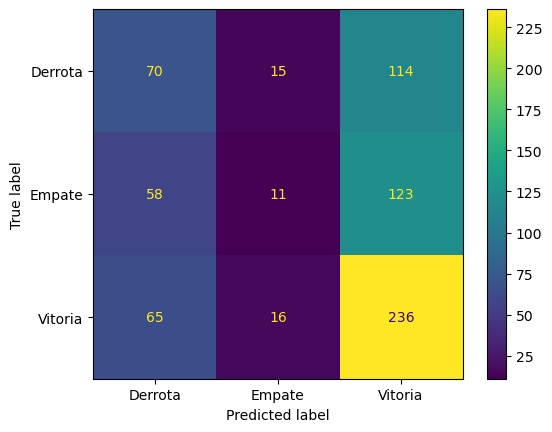

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### Floresta aleatória

#### Escolhendo hiperparâmetros

In [17]:
params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', 1.0],
    'max_samples': [0.2, 0.6, 1.0]
}

In [18]:
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=params, cv=5, n_jobs=-1, verbose=9)

In [19]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8],
                         'max_features': ['sqrt', 'log2', 1.0],
                         'max_samples': [0.2, 0.6, 1.0],
                         'n_estimators': [100, 500, 1000]},
             verbose=9)

#### Avaliando classificador

In [20]:
y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Derrota       0.47      0.42      0.44       199
      Empate       0.27      0.05      0.08       192
     Vitoria       0.52      0.81      0.63       317

    accuracy                           0.49       708
   macro avg       0.42      0.43      0.39       708
weighted avg       0.44      0.49      0.43       708



In [21]:
grid_search.best_params_

{'max_depth': 6, 'max_features': 1.0, 'max_samples': 0.2, 'n_estimators': 100}

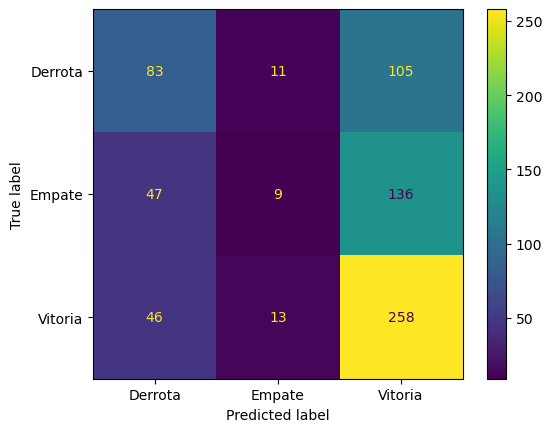

In [22]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### SVM

#### Escolhendo hiperparâmetros

In [23]:
tuned_parameters = {
    "kernel": ["rbf", "linear"],
    "gamma": [0.01, 0.001, 0.0001],
    "C": [1, 10, 100, 1000]
}

In [24]:
grid_search = GridSearchCV(SVC(), param_grid=tuned_parameters, n_jobs=-1, verbose=9)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=9)

In [25]:
grid_search.best_params_

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

#### Avaliando classificador

In [26]:
y_pred = grid_search.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Derrota       0.52      0.54      0.53       199
      Empate       0.36      0.08      0.13       192
     Vitoria       0.57      0.83      0.68       317

    accuracy                           0.54       708
   macro avg       0.48      0.48      0.44       708
weighted avg       0.50      0.54      0.49       708



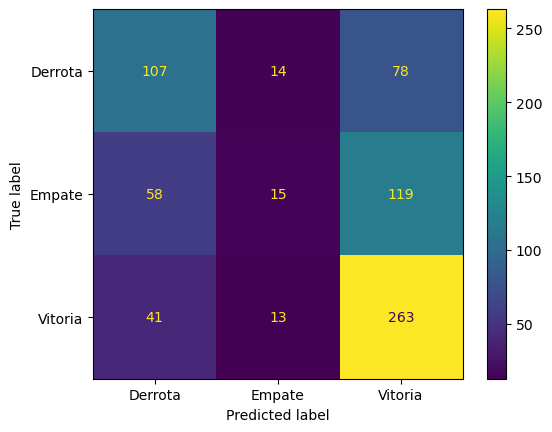

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## Resultados

## Conclusões e Discussões